## Performance test for Anderson Acceleration using the Graduate Admission Data set

In [ ]:
# !git clone https://code.ornl.gov/accelerated_training/accelerated_deeplearning_training.git
!unzip /content/accelerated_deeplearning_training-master.zip -d accelerated_deeplearning_training-master
%cd /content/accelerated_deeplearning_training-master
!python setup.py install

Archive:  /content/accelerated_deeplearning_training-master.zip
  inflating: accelerated_deeplearning_training-master/.gitignore  
   creating: accelerated_deeplearning_training-master/AADL/
  inflating: accelerated_deeplearning_training-master/AADL/__init__.py  
  inflating: accelerated_deeplearning_training-master/AADL/accelerate.py  
  inflating: accelerated_deeplearning_training-master/AADL/anderson_acceleration.py  
  inflating: accelerated_deeplearning_training-master/anderson_acceleration.py  
   creating: accelerated_deeplearning_training-master/datasets/
  inflating: accelerated_deeplearning_training-master/datasets/graduate_admission.csv  
   creating: accelerated_deeplearning_training-master/examples/
   creating: accelerated_deeplearning_training-master/examples/CIFAR10/
   creating: accelerated_deeplearning_training-master/examples/CIFAR10/big_nn/
  inflating: accelerated_deeplearning_training-master/examples/CIFAR10/big_nn/main.py  
   creating: accelerated_deeplearning_t

In [ ]:
import sys
import time
import torch
import numpy as np



sys.path.append('/content/accelerated_deeplearning_training-master/examples/graduate_admission')
from graduate_admission_dataloader import dataloader
sys.path.append('/content/accelerated_deeplearning_training-master/model_zoo')
from NN_models import MLP

import AADL as AADL
from anderson_acceleration import *

In [ ]:
# test dataloader
input_dim, output_dim, training_dataloader, validation_dataloader = dataloader('graduate_admission', 0.99, 512)
# 

# test network model
num_neurons = 64
num_layers  = 3
num_neurons_list = [num_neurons for i in range(num_layers)]

model = MLP(input_dim, output_dim, num_neurons_list, use_bias=True, activation='relu')

In [ ]:
loss_fun = torch.nn.MSELoss()
niters = 2000
lr = 0.02

print_freq = 100
start_time = time.time() 
print((2 * "%7s    ") % ("step", "Loss"))



relaxation = 1.
wait_iterations = 1
history_depth = 15
store_each_nth = 10
frequency = 5
reg_acc = 0
average = False


# optim = torch.optim.Adam(model.parameters(), lr=lr)
# accelerate.accelerate(optim, "anderson", relaxation, wait_iterations, history_depth, store_each_nth, frequency, reg_acc, average)
# accelerate(optim, frequency = frequency)

X, Y = next(iter(training_dataloader))

record = torch.zeros(niters+1, 10)
for repeat in range(10):
    model = MLP(input_dim, output_dim, num_neurons_list, use_bias=True, activation='relu')
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    AADL.accelerate(optim, "anderson", relaxation, wait_iterations, history_depth, store_each_nth, frequency, reg_acc, average)
    # accelerate(optim, frequency = 10)
    record[0,repeat] = loss_fun(model(X), Y)

    for itr in range(1, niters+1):
        def closure():
            optim.zero_grad()
            loss = loss_fun(model(X), Y)
            res  = torch.flatten(model(X) - Y)
            loss.backward()
            return loss
        optim.step(closure)

        with torch.no_grad():
            loss_itr = loss_fun(model(X), Y)
        record[itr, repeat] = loss_itr
        if itr % print_freq == 0:
            print(("%06d    " + "%1.4e    ") %(itr, loss_itr))
            
        if itr % 1000 == 0:
            for p in optim.param_groups:
                p['lr'] *= 0.2


    # validation
    X_val, Y_val = next(iter(validation_dataloader))
    loss_val = loss_fun(model(X_val), Y_val)

    print('validation error: ', loss_val)
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

   step       Loss    
000100    2.9974e-03    
000200    2.0333e-03    
000300    1.1451e-03    
000400    7.6000e-04    
000500    5.2958e-04    
000600    6.7359e-04    
000700    3.1323e-03    
000800    3.0564e-04    
000900    1.8922e-04    
001000    2.9058e-04    
001100    1.2053e-04    
001200    1.0066e-04    
001300    8.7826e-05    
001400    7.7573e-05    
001500    7.0599e-05    
001600    6.3060e-05    
001700    5.8036e-05    
001800    5.3086e-05    
001900    4.6117e-05    
002000    4.1566e-05    
validation error:  tensor(0.0129, grad_fn=<MseLossBackward>)
000100    3.7528e-03    
000200    2.9456e-03    
000300    2.4059e-03    
000400    1.9350e-03    
000500    1.3639e-03    
000600    8.7962e-04    
000700    5.9212e-04    
000800    4.4735e-04    
000900    3.3641e-04    
001000    3.8683e-04    
001100    2.7882e-04    
001200    2.4535e-04    
001300    2.1764e-04    
001400    1.9547e-04    
001500    1.7759e-04    
001600    1.5671e-04    
001700    1.4002

In [ ]:
record_accelerated = record

In [ ]:
record0 = record

In [ ]:
record_AADL = record

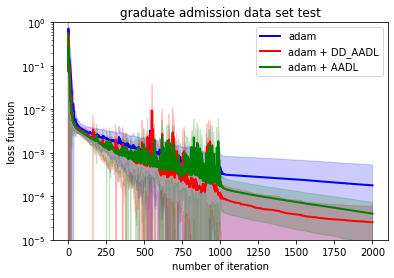

In [ ]:
import matplotlib.pyplot as plt


adam_anderson_avg = torch.mean(record_accelerated,axis=1).detach()
adam_anderson_std = torch.std(record_accelerated,axis=1).detach()
adam_avg = torch.mean(record0,axis=1).detach()
adam_std = torch.std(record0,axis=1).detach()

fig = plt.figure()
plt.plot(range(niters+1),adam_avg, color='b', linewidth=2)
plt.fill_between(range(niters+1), adam_avg-adam_std,adam_avg+adam_std,color='b',alpha=.2)
plt.plot(range(niters+1),adam_anderson_avg, color='r', linewidth=2)
plt.fill_between(range(niters+1), adam_anderson_avg-adam_anderson_std,adam_anderson_avg+adam_anderson_std,color='r',alpha=.2)


adam_avg_AADL = torch.mean(record_AADL,axis=1).detach()
adam_std_AADL = torch.std(record_AADL,axis=1).detach()
plt.plot(range(niters+1),adam_avg_AADL, color='g', linewidth=2)
plt.fill_between(range(niters+1), adam_avg_AADL-adam_std_AADL,adam_avg_AADL+adam_std_AADL,color='g',alpha=.2)


plt.yscale('log')
plt.ylim([1.e-5, 1])
plt.legend(['adam', 'adam + DD_AADL','adam + AADL'])

plt.xlabel('number of iteration')
plt.ylabel('loss function')
plt.title('graduate admission data set test')
fig.savefig('file.jpg', dpi=500)